In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from utils.training_utils import cross_validate, nested_cross_validation
from utils.prediction_utils import predict_with_estimator


from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
from utils.feature_importance_utils import get_shap_values
import shap
from copy import deepcopy


from config_models import MODELS
from config_preprocess import PREPROCESS_STEPS, PARAM_GRID

/Users/samtran/anaconda3/envs/python3.9/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2024-10-06 17:34 - DEBUG - matplotlib data path: /Users/samtran/anaconda3/envs/python3.9/lib/python3.9/site-packages/matplotlib/mpl-data
2024-10-06 17:34 - DEBUG - CONFIGDIR=/Users/samtran/.matplotlib
2024-10-06 17:34 - DEBUG - interactive is False
2024-10-06 17:34 - DEBUG - platform is darwin
2024-10-06 17:34 - DEBUG - CACHEDIR=/Users/samtran/.matplotlib
2024-10-06 17:34 - DEBUG - Using fontManager instance from /Users/samtran/.matplotlib/fontlist-v330.json


# Read Data

In [2]:
# read toy data
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


METRICS = ['auc', 'accuracy']


# Nested Cross Validation

In [4]:
import functools

# set params except for random_state
inner_cv = functools.partial(KFold, n_splits=3, shuffle=True)
outer_cv = functools.partial(KFold, n_splits=3, shuffle=True)

for model_name, model, model_param_grid in MODELS:
    print('---'*10 + ' ' + model_name.upper() + ' ' + "---"*10)
    pipeline = deepcopy(PREPROCESS_STEPS)
    pipeline.steps.append(['model',model])
    
    param_grid = deepcopy(PARAM_GRID)
    param_grid.update(model_param_grid)
    
    nested_cross_validation(X, y, 3, inner_cv, outer_cv, GridSearchCV, pipeline, param_grid, METRICS)

------------------------------ SVC ------------------------------
2024-10-06 17:34 - INFO - AUC:0.9413 +- 0.0093
2024-10-06 17:34 - INFO - ACCURACY:0.9467 +- 0.0088
------------------------------ LR ------------------------------
2024-10-06 17:34 - INFO - AUC:0.9517 +- 0.0049
2024-10-06 17:34 - INFO - ACCURACY:0.9578 +- 0.0038
------------------------------ KNC ------------------------------
2024-10-06 17:34 - INFO - AUC:0.8842 +- 0.0086
2024-10-06 17:34 - INFO - ACCURACY:0.9033 +- 0.0038


# Cross Validation

In [5]:
cv = KFold(n_splits=3, shuffle=True, random_state=1)

BEST_ESTIMATOR = {}
RESULTS = {}
for model_name, model, model_param_grid in MODELS:
    print('---'*10 + ' ' + model_name.upper() + ' ' + "---"*10)
    pipeline = deepcopy(PREPROCESS_STEPS)
    pipeline.steps.append(['model',model])
    
    param_grid = deepcopy(PARAM_GRID)
    param_grid.update(model_param_grid)
    
    best_estimators_dict_by_metric = cross_validate(X=X_train, y=y_train, repeated_cv_func=cv, param_grid=param_grid,
                                                pipeline=pipeline, target_metrics=METRICS, search_cv_func=GridSearchCV)
    
    best_estimator = best_estimators_dict_by_metric['auc']
    results = predict_with_estimator(best_estimator, X_train, y_train, X_test, y_test)
    RESULTS[model_name] = results 
    BEST_ESTIMATOR[model_name] = best_estimator
    
    

------------------------------ SVC ------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

2024-10-06 17:34 - INFO - Finding the best estimator for metric: auc
2024-10-06 17:34 - INFO - Best score for auc: 0.9309006625264414


 50%|█████     | 1/2 [00:02<00:02,  2.52s/it]

2024-10-06 17:34 - INFO - Finding the best estimator for metric: accuracy
2024-10-06 17:34 - INFO - Best score for accuracy: 0.9384803067270825


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


------------------------------ LR ------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

2024-10-06 17:34 - INFO - Finding the best estimator for metric: auc
2024-10-06 17:34 - INFO - Best score for auc: 0.950560551751548


 50%|█████     | 1/2 [00:00<00:00,  4.68it/s]

2024-10-06 17:34 - INFO - Finding the best estimator for metric: accuracy
2024-10-06 17:34 - INFO - Best score for accuracy: 0.9538892761705587


100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


------------------------------ KNC ------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

2024-10-06 17:34 - INFO - Finding the best estimator for metric: auc
2024-10-06 17:34 - INFO - Best score for auc: 0.8882189889397946


 50%|█████     | 1/2 [00:00<00:00,  2.18it/s]

2024-10-06 17:34 - INFO - Finding the best estimator for metric: accuracy
2024-10-06 17:34 - INFO - Best score for accuracy: 0.909869873358894


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


# Test Results

In [6]:
BEST_ESTIMATOR

{'svc': Pipeline(steps=[('drop', DropCorrelatedFeatures()),
                 ('sampling',
                  RandomUnderSampler(random_state=18, sampling_strategy=1)),
                 ('reduce_dim', PCA(iterated_power=7, n_components=10)),
                 ('scaler', StandardScaler()),
                 ['model', SVC(degree=2, gamma=0.1)]]),
 'lr': Pipeline(steps=[('drop', DropCorrelatedFeatures()),
                 ('sampling',
                  RandomOverSampler(random_state=18, sampling_strategy=1)),
                 ('reduce_dim', PCA(iterated_power=7, n_components=10)),
                 ('scaler', StandardScaler()),
                 ['model',
                  LogisticRegression(penalty='l1', solver='liblinear')]]),
 'knc': Pipeline(steps=[('drop', DropCorrelatedFeatures()),
                 ('sampling',
                  RandomUnderSampler(random_state=18, sampling_strategy=1)),
                 ('reduce_dim', PCA(iterated_power=7, n_components=10)),
                 ('scaler', St

In [7]:
pd.DataFrame(data=RESULTS)

,svc,lr,knc
accuracy,0.938596,0.938596,0.877193
precision,0.957143,0.957143,0.870130
sensitivity,0.943662,0.943662,0.943662
specificity,0.930233,0.930233,0.767442
f1,0.950355,0.950355,0.905405
auc,0.936947,0.936947,0.855552
ppv,0.957143,0.957143,0.870130
npv,0.909091,0.909091,0.891892


# Feature Importance

In [11]:
shap_values = {}
explainers = {}
obs = {}
for k,v in BEST_ESTIMATOR.items():
    obs[k], explainers[k], shap_values[k] = get_shap_values(v, X_train, y_train, X_test, y_test, sample=5)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-10-06 17:35 - DEBUG - weight_vector = array([0.39276196, 0.2209286 , 0.16832655, 0.14728573, 0.07069715])
2024-10-06 17:35 - DEBUG - num_subset_sizes = 5
2024-10-06 17:35 - DEBUG - num_paired_subset_sizes = 4
2024-10-06 17:35 - DEBUG - self.M = 10
2024-10-06 17:35 - DEBUG - subset_size = 1
2024-10-06 17:35 - DEBUG - nsubsets = 20.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 401.4027212792817
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 20.070136063964085
2024-10-06 17:35 - DEBUG - subset_size = 2
2024-10-06 17:35 - DEBUG - nsubsets = 90.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 364.5530145530144
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 4.050589050589049
2024-10-06 17:35 - DEBUG - subset_size = 3
2024-10-06 17:35 - DEBUG - nsubsets = 240.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 397.3856209150324
2024-10-06 17:35 - 

  0%|          | 0/5 [00:00<?, ?it/s]

2024-10-06 17:35 - DEBUG - weight_vector = array([0.39276196, 0.2209286 , 0.16832655, 0.14728573, 0.07069715])
2024-10-06 17:35 - DEBUG - num_subset_sizes = 5
2024-10-06 17:35 - DEBUG - num_paired_subset_sizes = 4
2024-10-06 17:35 - DEBUG - self.M = 10
2024-10-06 17:35 - DEBUG - subset_size = 1
2024-10-06 17:35 - DEBUG - nsubsets = 20.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 401.4027212792817
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 20.070136063964085
2024-10-06 17:35 - DEBUG - subset_size = 2
2024-10-06 17:35 - DEBUG - nsubsets = 90.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 364.5530145530144
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 4.050589050589049
2024-10-06 17:35 - DEBUG - subset_size = 3
2024-10-06 17:35 - DEBUG - nsubsets = 240.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 397.3856209150324
2024-10-06 17:35 - 

  0%|          | 0/5 [00:00<?, ?it/s]

2024-10-06 17:35 - DEBUG - weight_vector = array([0.39276196, 0.2209286 , 0.16832655, 0.14728573, 0.07069715])
2024-10-06 17:35 - DEBUG - num_subset_sizes = 5
2024-10-06 17:35 - DEBUG - num_paired_subset_sizes = 4
2024-10-06 17:35 - DEBUG - self.M = 10
2024-10-06 17:35 - DEBUG - subset_size = 1
2024-10-06 17:35 - DEBUG - nsubsets = 20.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 401.4027212792817
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 20.070136063964085
2024-10-06 17:35 - DEBUG - subset_size = 2
2024-10-06 17:35 - DEBUG - nsubsets = 90.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 364.5530145530144
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 4.050589050589049
2024-10-06 17:35 - DEBUG - subset_size = 3
2024-10-06 17:35 - DEBUG - nsubsets = 240.0
2024-10-06 17:35 - DEBUG - self.nsamples*weight_vector[subset_size-1] = 397.3856209150324
2024-10-06 17:35 - 

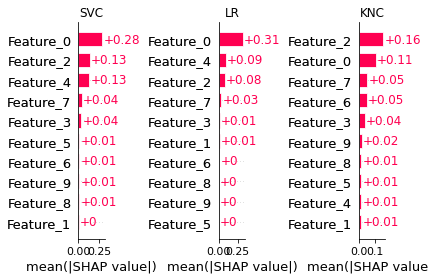

In [12]:
fig, axes = plt.subplots(1,len(BEST_ESTIMATOR), facecolor=(1, 1, 1), )
for i,v in enumerate(BEST_ESTIMATOR.keys()):
    shap.plots.bar(shap_values[v], ax=axes[i], show=False)
    axes[i].set_title(v.upper())
fig.tight_layout()


2024-10-06 17:35 - DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x16dd42cd0>
2024-10-06 17:35 - DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x16de12520>
2024-10-06 17:35 - DEBUG - locator: <matplotlib.ticker.FixedLocator object at 0x16ded5790>


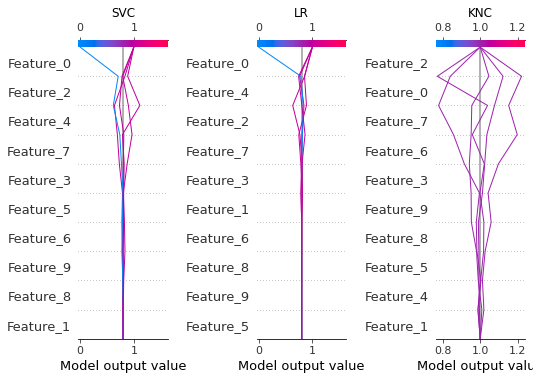

In [13]:
plt. subplots_adjust(wspace=1.)
for i,v in enumerate(BEST_ESTIMATOR.keys()):
    plt.subplot(1,len(BEST_ESTIMATOR),i+1)
    shap.decision_plot(explainers[v].expected_value, shap_values[v].values, obs[v].columns, show=False)
    plt.title(v.upper())
